In [1]:
from IPython.core.debugger import set_trace

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot_ng as pydot


import sys
sys.path.append('../financial_utils/')

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

import performance as per

C:\Users\Jon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATASET

### Load and Compute Returns

In [39]:
price_table = pd.read_csv('history_files/SPY.csv')
vol_table = pd.read_csv('history_files/VIX.csv')

# Build Tick Table
tick_table = price_table[['Date','Close','Open','High','Low']]
tick_table.columns = ['Date', 'Tick','Open','High','Low']
# Get Return Table
returns, other_returns = per.tick2ret_pivoted(tick_table)
data_dict = {'Date':tick_table.Date[1:], 
              'ReturnClose': returns[:,0], 'ReturnOpen': other_returns[:,0],
              'ReturnHigh': other_returns[:,1], 'ReturnLow': other_returns[:,2]}
returns_table = pd.DataFrame(data=data_dict,columns=data_dict.keys())
returns_table = returns_table.set_index('Date')

# Drop columns of Vol Table
vol_table = vol_table[['Date', 'Close','Open','High','Low']]
vol_table.columns = ['Date', 'VolClose','VolOpen','VolHigh','VolLow']
vol_table.VolClose = vol_table.VolClose/100
vol_table.VolOpen = vol_table.VolOpen/100
vol_table.VolHigh = vol_table.VolHigh/100
vol_table.VolLow = vol_table.VolLow/100
vol_table = vol_table.set_index('Date')

# InnerJoin
retvol_table = pd.concat([returns_table,vol_table], join='inner', axis=1)


In [74]:
T_x = 10
n_fields = retvol_table.shape[1]
T_y = 1
T_stride = 1

### Generate Dataset

In [75]:
def gen_dataset(T_x, T_y, n_fields, T_stride, retvol_table):
    """
    
    
    return
        x E (m, T_x)
        y E (m, T_y)
    """
    
    m = int(np.floor((returns.shape[0] - T_x) / T_stride))
    
    x = np.nan * np.ones((m-T_y*T_stride, T_x, n_fields))
    y = np.nan * np.ones((m-T_y*T_stride, T_y, n_fields))
    
    for i in range(m-T_y*T_stride):
        for j in range(retvol_table.shape[1]):
            x[i,:,j] = retvol_table.iloc[i*T_stride:i*T_stride+T_x,j].transpose()
            y[i,:,j] = retvol_table.iloc[i*T_stride+T_x:i*T_stride+T_x+T_y,j].transpose()
            
    return x, y, m

In [76]:
def normalize_data(x, params=None):
    """
    
    return 
        x_norm
        x_norm_param = (mean, std)
    """
    if params == None:
        mean = np.mean(x, axis=(0,1)) 
        std = np.std(x, axis=(0,1))
    else:
        mean = params[0]
        std = params[1]
    x_norm_param = (mean, std)
    x_norm = (x - mean)/std
    
    return x_norm, x_norm_param

In [77]:
def denormalize_data(x_norm, x_norm_param):
    """"""
    
    mean = x_norm_param[0]
    std = x_norm_param[1]
    x = x_norm * std + mean
    
    return x

In [78]:
x, y, m = gen_dataset(T_x,T_y, n_fields, T_stride,retvol_table)
x, x_norm_param = normalize_data(x)
y, _ = normalize_data(y, x_norm_param)
print('Training Example: '+str(m))
print('X Shape: '+str(x.shape))
print('Y Shape: '+str(y.shape))

Training Example: 6085
X Shape: (6084, 10, 8)
Y Shape: (6084, 1, 8)


### Train / Val / Test

In [79]:
x,y = shuffle(x,y)

train_end = int(m * 0.7)

val_end = train_end + int(0.15 * m)

x_train = x[0:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]

y_train = y[0:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

# Keras Model

### Encoder- Decoder

In [120]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
relu_out = keras.layers.Dense(units = n_fields, activation='tanh')
concatenator = keras.layers.Lambda(lambda x: keras.backend.stack(x, axis=1))
reshapor_Ty1 = keras.layers.Reshape((n_fields,))

In [127]:
def define_model(T_x, T_y, n_fields, n_a):
    
    x_input = keras.layers.Input(shape=(T_x, n_fields))
    output_seq = list()
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    for _ in range(T_y):
        decoder_outputs, decoder_h, decoder_c = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
        decoder_outputs_flat = flatter(decoder_outputs)
        out = dense(decoder_outputs_flat)
        out = relu_out(out)
        
        output_seq.append(out)
        deco_input = decoder_outputs
        
    if T_y != 1:    
        output_seq = concatenator(output_seq)
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=output_seq)
    return model

In [128]:
model = define_model(T_x, T_y, n_fields, n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 8)        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 43600       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1, 100), (No 80400       input_8[0][0]                    
                                                                 lstm_1[3][1]                     
          

In [129]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [134]:
decoder_in = np.zeros((x_train.shape[0],1,n_a))
decoder_val = np.zeros((x_val.shape[0],1,n_a))
if T_y!=1:
    history = model.fit(x=[x_train,decoder_in], y=y_train,
              validation_data = ([x_val, decoder_val], y_val),
              shuffle=True, epochs = 10)
else:
    history = model.fit(x=[x_train,decoder_in], y=y_train[:,0,:],
              validation_data = ([x_val, decoder_val], y_val[:,0,:]),
              shuffle=True, epochs = 10)


Train on 4259 samples, validate on 912 samples
Epoch 1/10
4259/4259 [==============================] - 2s 403us/step - loss: 0.5726 - acc: 0.4360 - val_loss: 0.6082 - val_acc: 0.4715
Epoch 2/10
4259/4259 [==============================] - 2s 396us/step - loss: 0.5697 - acc: 0.4424 - val_loss: 0.6096 - val_acc: 0.4715
Epoch 3/10
4259/4259 [==============================] - 2s 395us/step - loss: 0.5665 - acc: 0.4482 - val_loss: 0.6091 - val_acc: 0.4737
Epoch 4/10
4259/4259 [==============================] - 2s 395us/step - loss: 0.5636 - acc: 0.4447 - val_loss: 0.6101 - val_acc: 0.4068
Epoch 5/10
4259/4259 [==============================] - 2s 401us/step - loss: 0.5650 - acc: 0.4419 - val_loss: 0.6066 - val_acc: 0.4715
Epoch 6/10
4259/4259 [==============================] - 2s 395us/step - loss: 0.5599 - acc: 0.4433 - val_loss: 0.6095 - val_acc: 0.4846
Epoch 7/10
4259/4259 [==============================] - 2s 397us/step - loss: 0.5561 - acc: 0.4435 - val_loss: 0.6126 - val_acc: 0.4759
E

<IPython.core.display.Javascript object>


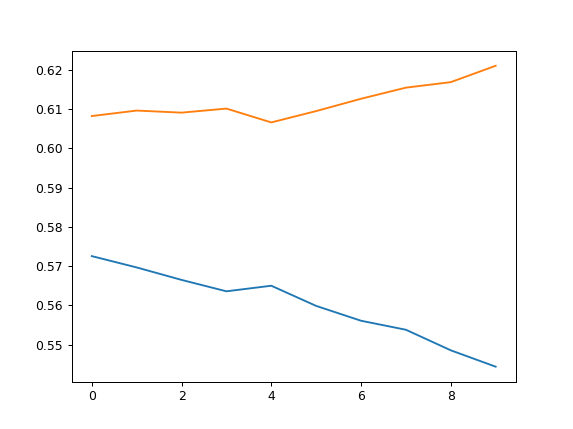

In [135]:
plt.figure()
plt.plot(history.epoch, history.history["loss"], label='Train Loss')
plt.plot(history.epoch, history.history["val_loss"], label='Vali Loss')

In [63]:
decoder_in = np.zeros((x_train.shape[0],1,n_a))
evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train)
decoder_in = np.zeros((x_val.shape[0],1,n_a))
evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val)
print('Test Error: '+ str(evalu_test))
print('Val  Error: '+ str(evalu_val))

912/912 [==============================] - 0s 117us/step
Test Error: [0.3203677449967554, 0.807936135998744]
Val  Error: [0.6700376000320702, 0.3351608180163199]


### Visualization

In [72]:
data_set = (x_val, y_val)
indexes = np.random.randint(0,data_set[0].shape[0], size=1)
x_in = data_set[0][indexes,:,:]
decoder_in = np.zeros((x_in.shape[0],1,n_a))
y_true = data_set[1][indexes,:,:]
y_pred = model.predict(x=[x_in,decoder_in])
y_pred_denorm = denormalize_data(y_pred, x_norm_param)
print('X:')
print(denormalize_data(x_in,x_norm_param))
print('Y:')
print(denormalize_data(y_true,x_norm_param))
print('LSTM Out:')
print(y_pred)
print('Y pred:')
print(y_pred_denorm)

X:
[[[-0.01032373 -0.00701611  0.00080185 -0.01874306  0.19389999
    0.1933      0.1973      0.18860001]
  [ 0.0198501   0.00921616  0.02187567  0.00921616  0.20059999
    0.1999      0.2032      0.1984    ]
  [ 0.00446877 -0.00198607  0.00585903 -0.00526315  0.1948
    0.19959999  0.20049999  0.19370001]
  [-0.0056352  -0.00227389  0.00247158 -0.01107269  0.1893
    0.195       0.19629999  0.1893    ]
  [-0.01272618 -0.00735739 -0.00536887 -0.0193876   0.19190001
    0.1926      0.195       0.19049999]
  [ 0.00946621  0.0009063   0.01158101  0.0009063   0.18469999
    0.1875      0.18889999  0.1826    ]
  [ 0.00488832  0.00957701  0.0165603   0.00209496  0.1959
    0.18879999  0.1967      0.18700001]
  [-0.00218407  0.00645283  0.00724706 -0.00774353  0.19549999
    0.19700001  0.1993      0.19379999]
  [-0.0058701   0.00298474  0.00358174 -0.01273504  0.1976
    0.19709999  0.2015      0.1966    ]
  [-0.01421135 -0.00770613 -0.00040033 -0.01761403  0.20219999
    0.19799999  0.20450

<IPython.core.display.Javascript object>


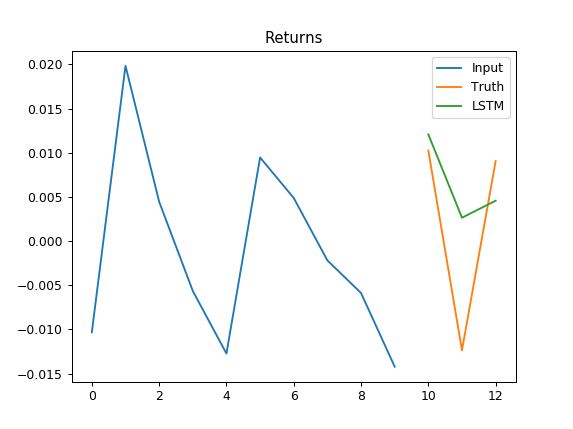

<IPython.core.display.Javascript object>


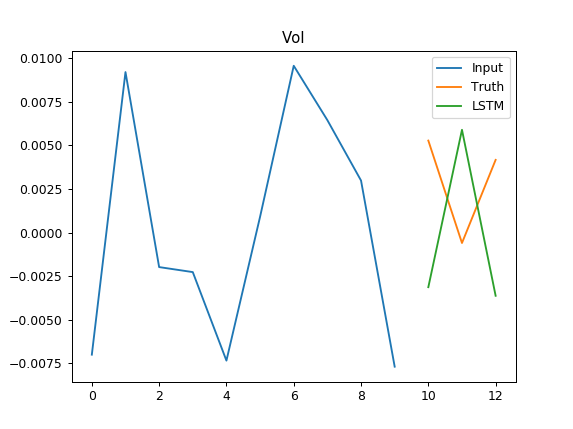

In [73]:
x_in_returns = denormalize_data(x_in,x_norm_param)[:,:,0].transpose()
x_in_vol = denormalize_data(x_in,x_norm_param)[:,:,1].transpose()
y_true_returns = denormalize_data(y_true,x_norm_param)[:,:,0].transpose()
y_true_vol = denormalize_data(y_true,x_norm_param)[:,:,1].transpose()
y_pred_returns = denormalize_data(y_pred,x_norm_param)[:,:,0].transpose()
y_pred_vol = denormalize_data(y_pred,x_norm_param)[:,:,1].transpose()
plt.figure()
plt.plot(range(0,T_x), x_in_returns, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_returns, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_returns, label='LSTM')
plt.title('Returns')
plt.legend()

plt.figure()
plt.plot(range(0,T_x), x_in_vol, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_vol, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_vol, label='LSTM')
plt.title('Vol')
plt.legend()

## SNIPPETS

### Norm - Denorm Check

In [ ]:
a, b , m = gen_dataset(T_x,T_y,T_stride,retvol_table)
x, x_norm_param = normalize_data(a)
y, _ = normalize_data(b, x_norm_param)
x = denormalize_data(x, x_norm_param)
y = denormalize_data(y, x_norm_param)

plt.figure()
plt.hist((b-y).flatten(), 100)

In [ ]:
class PlotHistory(keras.callbacks.History):
    def on_train_begin(self, logs=None):
        super().on_train_begin(logs)
        self.fig = plt.figure()
        self.axes = plt.subplot(111)
        self.trainloss_line, = self.axes.plot([],[], label='Train Loss')
        self.fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1,right=0.85, wspace=0, hspace=0) 
        self.fig.canvas.draw()
        
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.trainloss_line.set_data(self.epoch, self.history["loss"])
        self.axes.relim()
        self.fig.canvas.draw()
# Update of plot does not properly work